In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = "cpu"

cuda


In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [7]:
sentence_data = np.load('pretrain_sentence_frame_mapped_5.npy')

print("Shape : ", sentence_data.shape)

Shape :  (44, 2)


In [8]:
print(sentence_data[1])

[array([[9.08245116, 9.57190859, 7.3606882 , 2.39471474, 2.93789029],
       [0.18538806, 8.6268914 , 7.11740254, 2.41725098, 3.43868369],
       [0.31711825, 8.59112343, 7.50563423, 2.37794496, 2.75932135],
       ...,
       [0.659277  , 4.45868453, 5.51650798, 5.68924272, 1.63686612],
       [0.75631032, 4.47536279, 5.44316404, 5.70361058, 1.63636789],
       [0.68812483, 4.43647985, 5.54524397, 5.64771864, 1.63710168]])
 'blabla']


In [12]:
print(sentence_data.shape)

def get_sentence_data(num,n_data_pts):
    num = num%n_data_pts
#     num = num%sentence_data.shape[0]
    return [torch.FloatTensor(sentence_data[num][0]).to(device), sentence_data[num][1]]
#     return [torch.FloatTensor(sentence_data[1][0]).to(device), sentence_data[1][1]]
# print(get_sentence_data(0))

(44, 2)


In [13]:
window_length = 10
MAX_LENGTH = 10

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size # hidden size is 10 [10 frames]

        self.gru = nn.GRU(input_size, 5,hidden_size)
        self.bn1 = nn.BatchNorm1d(1)
        self.linear1 = nn.Linear(5,10)
        self.bn2 = nn.BatchNorm1d(1)
        self.linear3 = nn.Linear(10,10)
        self.bn3 = nn.BatchNorm1d(1)
        self.linear2 = nn.Linear(10,5)
        
    def forward(self, input, hidden):
#         print(input.shape)
        #input = torch.unsqueeze(input,0)
        embedded = torch.unsqueeze(input,1)
        output = embedded
        
#         print(output.shape)
#         print(hidden.shape)
        output, hidden = self.gru(output, hidden)
#         print("Hidden - ",hidden.shape)
        
        hidden = self.bn1(hidden)
        hidden = F.relu(hidden)
    
        temp = self.linear1(hidden)
        
        temp = self.bn2(temp)
        temp = F.relu(temp)
#         print('Temp - ',temp.shape)
        temp = self.linear3(temp)
        
        temp = self.bn3(temp)
        temp = F.relu(temp)
    
        temp = self.linear2(temp)
#         print('Updated temp - ',temp.shape)
        hidden = temp
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size, 1, 5, device=device)
        temp = self.linear2(temp)
#         print('Updated temp - ',temp.shape)
        hidden = temp
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size, 1, 5, device=device)

In [15]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
    if epoch <= 10:
        lr = 0.01
    elif epoch <= 20:
        lr = 0.001
    elif epoch <= 25:
        lr = 0.0001
    elif epoch <=35:
        lr = 0.00001
    else:
        lr = 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [16]:
def trainIters(encoder, n_iters,n_data_pts, print_every=10, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
#     n_data_pts = n_iters
#     n_iters = 300
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    training_pairs = np.array([get_sentence_data(i,n_data_pts) for i in range(n_data_pts)])
    randomselect = random.sample(range(training_pairs.shape[0]),training_pairs.shape[0])
    training_pairs = training_pairs[randomselect]
    criterion = nn.L1Loss()
    iter_loss = []

    for i in range(1,n_iters+1):
        lr = adjust_learning_rate(encoder_optimizer,i)
        print('Learning Rate: ', lr)
        for iter in range(1, n_data_pts + 1):
    #         if iter == 2:
    #             break
            training_pair = training_pairs[iter-1]
            input_tensor = training_pair[0]
    #         print(input_tensor.shape)
            target_tensor = training_pair[1]
            if input_tensor.size(0) < 21:
                pass
            else:
                loss = train(input_tensor, target_tensor, encoder,
                              encoder_optimizer,  criterion)
                print_loss_total += loss
                plot_loss_total += loss
        
        print_loss_total = print_loss_total / n_data_pts
        plot_loss_total = plot_loss_total / n_data_pts
        
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total #/ print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / (n_iters)),
                                         i, i / (n_iters) * 100, print_loss_avg))
        
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total #/ plot_every
            iter_loss.append(plot_loss_avg)
            plot_loss_total = 0
        
        torch.save(encoder1, 'pretrained_155_f5_v1')

    showPlot(iter_loss)
    
    return iter_loss

In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, encoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    ENCODER_WINDOW = 10
    ENCODER_SLIDE = 10 # previously 1
    
    encoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
#     print("Input Length: ",input_length)
    target_length = input_length

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
#     print("-----",input_tensor.shape)
    for ei in range(0,input_length,ENCODER_SLIDE):
        if ei < input_length-(ENCODER_WINDOW+ENCODER_SLIDE): # input_length-11:
#             print(ei,'-',ei+ENCODER_WINDOW)
            encoder_output, encoder_hidden = encoder(input_tensor[ei:ei+ENCODER_WINDOW], encoder_hidden)
            encoder_output = torch.squeeze(encoder_output)
#             print(encoder_hidden)
#             print(encoder_output.data.shape)
    #         encoder_outputs[ei] = encoder_output[0, 0]
            loss += criterion(encoder_output, input_tensor[ei+ENCODER_SLIDE:ei+ENCODER_SLIDE+ENCODER_WINDOW])
#             ei+=ENCODER_SLIDE
#     print(loss)
    loss.backward()

    encoder_optimizer.step()
    
    return loss.item() / target_length

In [16]:
hidden_size = 10
window_length = 5
MAX_LENGTH = 5
encoder1 = EncoderRNN(window_length, hidden_size).to(device)

plt_loss = trainIters(encoder1, 50 , 42, print_every=1, plot_every=1,learning_rate=0.01)
torch.save(encoder1, 'pretrained_155_f5_v1')

Learning Rate:  0.01
7m 52s (- 385m 40s) (1 2%) 0.3506
Learning Rate:  0.01


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


15m 45s (- 378m 18s) (2 4%) 0.1919
Learning Rate:  0.01
23m 44s (- 372m 2s) (3 6%) 0.1880
Learning Rate:  0.01
31m 44s (- 365m 6s) (4 8%) 0.1876
Learning Rate:  0.01
39m 38s (- 356m 42s) (5 10%) 0.1874
Learning Rate:  0.01
47m 33s (- 348m 47s) (6 12%) 0.1873
Learning Rate:  0.01
55m 28s (- 340m 45s) (7 14%) 0.1872
Learning Rate:  0.01
63m 24s (- 332m 52s) (8 16%) 0.1872
Learning Rate:  0.01
71m 21s (- 325m 4s) (9 18%) 0.1871
Learning Rate:  0.01
79m 8s (- 316m 34s) (10 20%) 0.1870
Learning Rate:  0.001
86m 52s (- 308m 0s) (11 22%) 0.1858
Learning Rate:  0.001
94m 22s (- 298m 50s) (12 24%) 0.1854
Learning Rate:  0.001
101m 54s (- 290m 2s) (13 26%) 0.1853
Learning Rate:  0.001
109m 34s (- 281m 44s) (14 28%) 0.1853
Learning Rate:  0.001
117m 12s (- 273m 28s) (15 30%) 0.1852
Learning Rate:  0.001
124m 39s (- 264m 54s) (16 32%) 0.1852
Learning Rate:  0.001
132m 13s (- 256m 39s) (17 34%) 0.1851
Learning Rate:  0.001
139m 45s (- 248m 28s) (18 36%) 0.1851
Learning Rate:  0.001
147m 17s (- 240m

KeyboardInterrupt: 

## Hyper-Parameter Tuning
#### 44 sentences , 0.01 lr, adam, shape 128, 64, epoch 4, loss 19.45 to 11.35       
#### 44 sentences, 0.01 lr, adam, shape same, epoch 50, loss, 19.5 to 10.02 - flat for last 45 epochs            --> retrain with 0.001 lr
#### 44 sentences, 0.001 lr, adam, shape same, epoch 15, loss 20 to 8.8
#### 44 sentences, 0.001 lr, adam, shape same, epoch 40, loss 21 to 8.38

In [12]:
# You can stop after this cell, all the below cells have miscellaneous code.

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateRandomBleu(encoder, decoder,n = 1000):
    count = 0
    bleu = 0
    for i in range(n):
        pair = random.choice(pairs)
#         print('>', pair[0])
#         print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
#         print('<', output_sentence)
#         print("BLEU = ",sentence_bleu(output_sentence,pair[1]))
        bleu+=sentence_bleu(output_sentence,pair[1])
        count+=1
    print("Average BLEU = ",bleu/count)

In [45]:
evaluateRandomBleu(encoder1, attn_decoder1)

Average BLEU =  0.850870240641


Text(0.5,1,u'Pretraining loss curve')

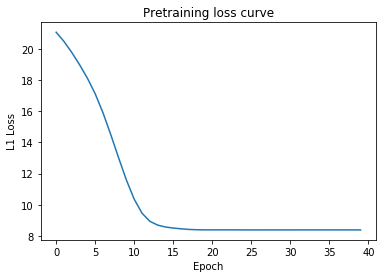

In [5]:
# print(plt_loss)
plt_loss = [21.086295206097013, 20.495831362059075, 19.786437528387662, 18.99678842936856, 18.133830379335844, 17.131665945305702, 15.908109154423364, 14.498725698655567, 13.014617763172696, 11.584699034275715, 10.353145313600374, 9.453177644158746, 8.934963498056574, 8.68917409891786, 8.564597499508956, 8.499453866019364, 8.450344860113946, 8.409526442773236, 8.391285570079484, 8.382780993024234, 8.382144897920632, 8.382953835031898, 8.383430364016965, 8.382003510666388, 8.379383924738432, 8.378945602179964, 8.37897179811216, 8.379407412454912, 8.379401724048286, 8.379643418876627, 8.379400271255859, 8.380087360117287, 8.379515963875308, 8.380575068268909, 8.37991573405953, 8.379985473360817, 8.379658934557288, 8.37974025586688, 8.379560913523418, 8.379618696016006]
#44 sentences, 0.001 lr, adam, shape same, epoch 40, loss 21 to 8.38
plt.plot(plt_loss)
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title('Pretraining loss curve')


[21.178397907781644, 21.10090734445524, 20.8345060396018, 20.36218133683622, 19.778148575681406, 19.09570589565627, 18.31068482112373, 17.423330460222985, 16.43959401072598, 15.376273917861205, 14.271030364769418, 13.197061769838593, 12.269401157477166, 11.610432485304006, 11.25356828807076, 11.142544183711083, 11.126949497278375, 11.112594290986074, 11.098897132056358, 11.085850334082057, 11.079050839582225, 11.07781957991548, 11.07658800676294, 11.075354224570667, 11.074122819800786, 11.073458027619056, 11.073333523559542, 11.073210461081267, 11.073086792175472, 11.072961959087321, 11.07283501613726, 11.072709169865021, 11.072582600903702, 11.072456846192308, 11.0723279059369, 11.072260399709997, 11.07225055155764, 11.072241183132295, 11.07223123398222, 11.072222066898265, 11.072212238812387, 11.072202452063486, 11.072192262130311, 11.072181919318027, 11.072172213478456, 11.072161547431296, 11.072151409954664, 11.072140374212925, 11.072129546189217, 11.0721197100016]


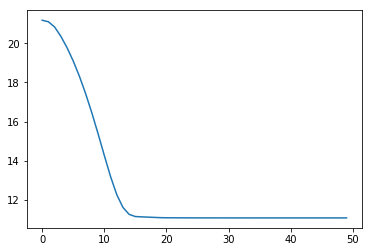

In [56]:
print(plt_loss)
#44 sentences, 0.001 lr, adam, shape same, epoch 40, loss 21 to 8.38
plt.plot(plt_loss)

# if epoch <= 15:
#     lr = 0.001
# elif epoch <= 20:
#     lr = 0.0001
# elif epoch <= 25:
#     lr = 0.00001
# elif epoch <=35:
#     lr = 0.000001
# else:
#     lr = 0.0000001

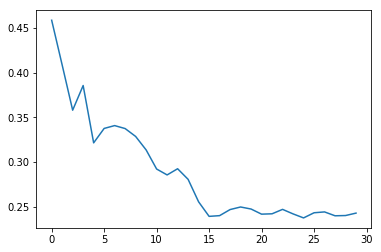

In [85]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
plt.plot(plt_loss)

In [24]:
enc = torch.load('pretrained_155_f5_v1')

In [62]:
dt = get_sentence_data(0,10)
dt = dt[0]
print(dt)

tensor([[0.1381, 8.5328, 5.8547, 3.3859, 4.0402],
        [0.0551, 8.7587, 5.9234, 3.3786, 3.2635],
        [9.0875, 9.8095, 5.9663, 3.2976, 3.1128],
        ...,
        [1.0059, 5.0216, 4.5123, 6.2965, 3.6978],
        [0.9853, 4.9965, 4.3684, 6.1697, 3.6662],
        [0.9514, 5.0046, 4.4447, 6.2373, 3.6657]], device='cuda:0')


In [76]:
ENCODER_WINDOW = 10
encoder_h1 = enc.initHidden()
encoder_h2 = enc.initHidden()
encoder_o1 = 0
encoder_o2 = 0
for ei in range(0,1):
    encoder_o1, encoder_h1 = enc(dt[ei:ei+ENCODER_WINDOW], encoder_h1)
    
for ei in range(5,6):
    encoder_o2, encoder_h2 = enc(dt[ei:ei+ENCODER_WINDOW], encoder_h2)

In [77]:
print(torch.dist(encoder_o1, encoder_o2,1))

tensor(0.0019, device='cuda:0', grad_fn=<DistBackward>)


In [60]:
print(torch.norm(encoder_o1-encoder_o2,1))

tensor(0.0026, device='cuda:0', grad_fn=<NormBackward0>)
